> From https://www.kaggle.com/code/alexj21/pytorch-eda-unet-from-scratch-finetuning/notebook

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
import os
import sys
import random
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(os.path.join('..')))
from helpers import PATHS, rle_decode, imshow_tensor_with_mask 

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 70

# Exploratory Data Analysis (EDA)

## Data

In [15]:
# Read CSV as dataframe
masks = pd.read_csv(os.path.join(PATHS['root'], 'train_ship_segmentations_v2.csv'))
print('Total number of images (original): %d' % masks['ImageId'].value_counts().shape[0])

# Create a dataframe with unique images id as indexes and number of ships and image sizes as new columns
masks = masks[~masks['ImageId'].isin(['6384c3e78.jpg'])] # remove corrupted file
unique_img_ids = masks.groupby('ImageId').size().reset_index(name='counts')
print('Total number of images (after removing corrupted images): %d' % masks['ImageId'].value_counts().shape[0])

masks

Total number of images (original): 192556
Total number of images (after removing corrupted images): 192555


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,NaN
231719,ffff2aa57.jpg,NaN
231720,ffff6e525.jpg,NaN
231721,ffffc50b4.jpg,NaN


## Images with and without ships

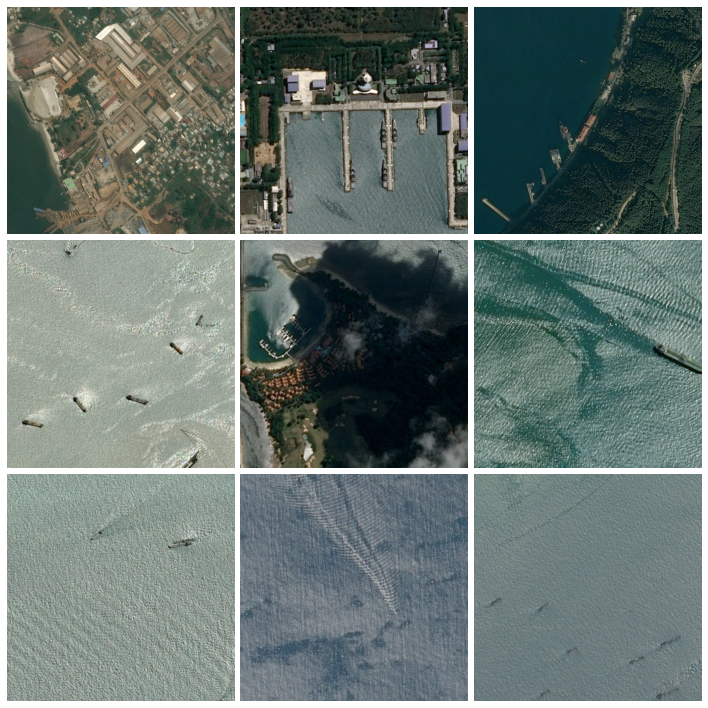

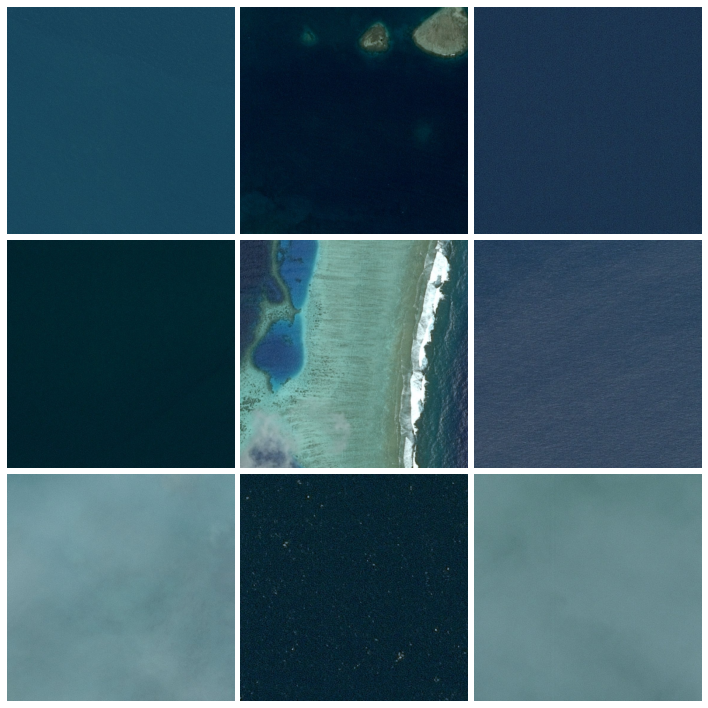

In [16]:
# Plot some images with ships
img_wships = masks[~masks['EncodedPixels'].isna()].sample(9)
fig, arr = plt.subplots(3,3, figsize=(10,10), constrained_layout=True)
for i, img in enumerate(img_wships['ImageId']):
    r = int(i / 3)
    c = i % 3
    arr[r,c].imshow(imread(os.path.join(PATHS['train'], img)))
    arr[r,c].axis('off')
plt.show()

# Plot some images without ships
img_woships = masks[masks['EncodedPixels'].isna()].sample(9)
fig, arr = plt.subplots(3,3, figsize=(10,10), constrained_layout=True)
for i, img in enumerate(img_woships['ImageId']):
    r = int(i / 3)
    c = i % 3
    arr[r,c].imshow(imread(os.path.join(PATHS['train'], img)))
    arr[r,c].axis('off')
plt.show()

# Explore dataset

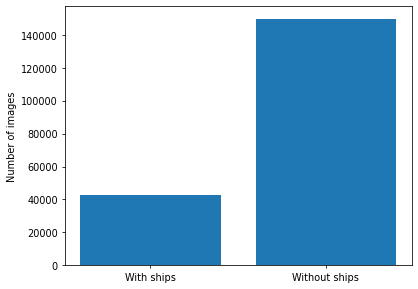

In [17]:
# Count number of ships per image
df_wships = masks.dropna()
df_wships = df_wships.groupby('ImageId').size().reset_index(name='counts')
df_woships = masks[masks['EncodedPixels'].isna()]

# Make a plot
plt.bar(['With ships','Without ships'], [len(df_wships), len(df_woships)])
plt.ylabel('Number of images')
plt.show()

From this we can see that the dataset is very unbalanced towards images with no ships (that are not very useful to us). Let's try to fix this by removing the images wihtout ships

## Balancing dataset

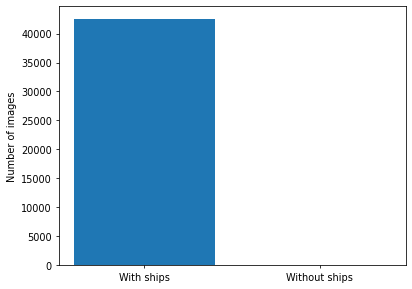

Number of images with ships : 42556 | Number of images without ships : 0  (x0.0)


In [18]:
# Remove images without ships to help getting a more balanced dataset
masks = masks.dropna()
df_woships = masks[masks['EncodedPixels'].isna()]

# Make a plot
plt.bar(['With ships','Without ships'], [len(df_wships), len(df_woships)])
plt.ylabel('Number of images')
plt.show()

print('Number of images with ships : %d | Number of images without ships : %d  (x%0.1f)' \
      % (df_wships.shape[0], df_woships.shape[0], df_woships.shape[0] / df_wships.shape[0]))

Much better!

## Further analysis

We can continue anayizing the available data, e.g. how many ships we have in each image

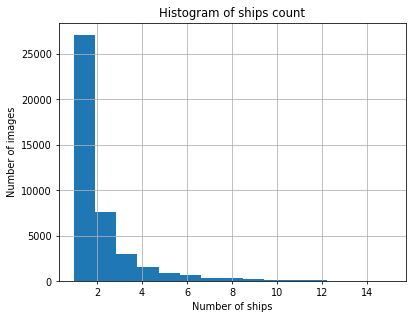

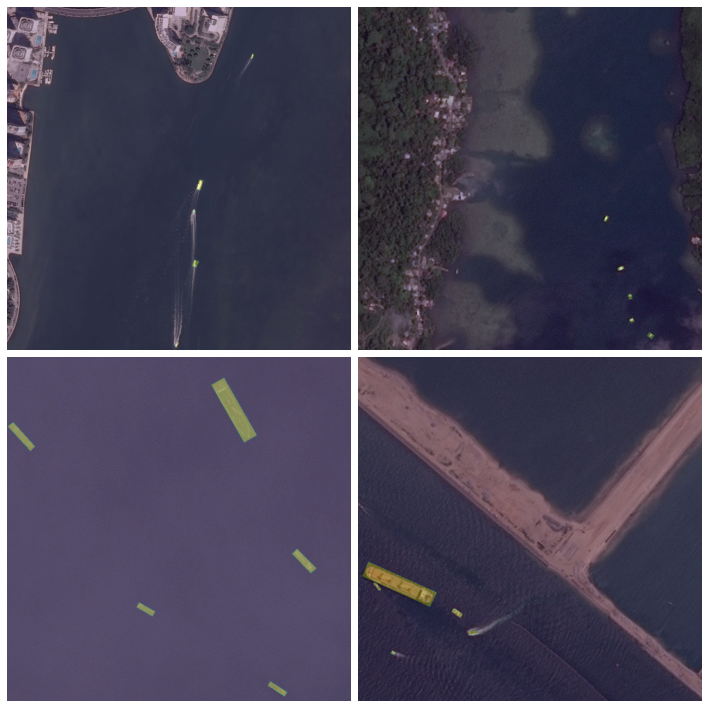

In [19]:
# Plot histogram
hist = df_wships.hist(bins=df_wships['counts'].max())
plt.title("Histogram of ships count")
plt.xlabel("Number of ships")
plt.ylabel("Number of images")
plt.show(hist)

# Plot images with 15 ships
df_w15ships = df_wships.loc[df_wships['counts'] == 5]
list_w15ships = df_w15ships.values.tolist()

fig, axarr = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)
for i in range(4):
    rd_id = random.randrange(len(list_w15ships))
    img_masks = masks.loc[masks['ImageId'] == str(list_w15ships[rd_id][0]), 'EncodedPixels'].tolist()

    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768))
    for mask in img_masks:
        all_masks += rle_decode(mask)
        
    r = int(i / 2)
    c = i % 2

    axarr[r][c].imshow(imread(os.path.join(PATHS['train'], list_w15ships[rd_id][0])))
    axarr[r][c].imshow(all_masks, alpha=0.3)
    axarr[r][c].axis('off')
                    
plt.show()

<br>

# Splitting into training and validation sets

In [20]:
unique_img_ids = masks.groupby('ImageId').size().reset_index(name='counts')

# We use stratify to balance the number of ships per image between the two df
train_ids, val_ids = train_test_split(unique_img_ids, test_size=0.05, stratify=unique_img_ids['counts'], random_state=42)

# Join (inner join) masks with the ids
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, val_ids)

# Update the counts, set to 0 all the cases where the mask is not a valid one (i.e. not a string)
train_df['counts'] = train_df.apply(lambda c_row: c_row['counts'] if isinstance(c_row['EncodedPixels'], str) else 0, 1)
valid_df['counts'] = valid_df.apply(lambda c_row: c_row['counts'] if isinstance(c_row['EncodedPixels'], str) else 0, 1)

### Check datasets

Number of training images : 40428


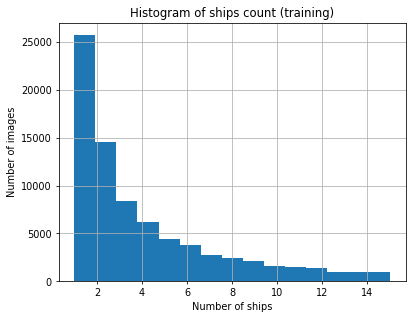

Number of validation images : 2128


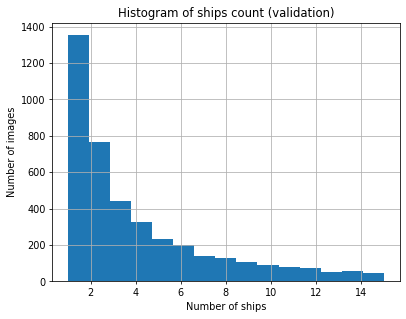

In [21]:
print('Number of training images : %d' % train_df['ImageId'].value_counts().shape[0])
train_df['counts'].hist(bins=train_df['counts'].max())
plt.title("Histogram of ships count (training)")
plt.xlabel("Number of ships")
plt.ylabel("Number of images")
plt.show()

print('Number of validation images : %d' % valid_df['ImageId'].value_counts().shape[0])
valid_df['counts'].hist(bins=valid_df['counts'].max())
plt.title("Histogram of ships count (validation)")
plt.xlabel("Number of ships")
plt.ylabel("Number of images")
plt.show()

We can see the same balance between the two datasets (thanks to stratify)!

<br>

# Custom Dataset test

We can also try to use our custom Dataset with the created dataframes

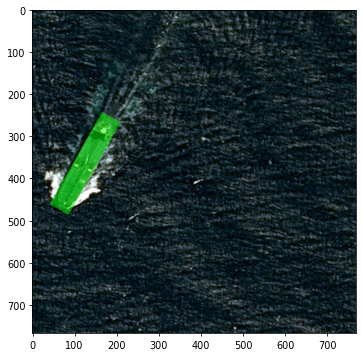

In [28]:
from dataset import AirbusDataset

dataset_valid = AirbusDataset(valid_df)

imshow_tensor_with_mask(*dataset_valid[33])

In [23]:
# The image
print(dataset_valid[0][0])

# The mask
print(dataset_valid[0][1])

tensor([[[-0.8164, -0.4568, -0.3712,  ..., -0.4226, -1.0219, -0.9020],
         [-0.7993, -0.3369, -0.7479,  ..., -0.6623, -0.5938, -0.6794],
         [-1.0048, -0.9705, -0.9192,  ..., -0.8164, -0.9363, -0.7993],
         ...,
         [-0.0287, -0.2513, -0.1486,  ..., -0.5596, -0.7137, -0.9192],
         [-0.2171, -0.3198, -0.1143,  ..., -1.0219, -1.3473, -0.9534],
         [-0.2513, -0.1828,  0.1083,  ..., -0.3198, -0.4568, -0.3883]],

        [[-0.1800,  0.1877,  0.2752,  ...,  0.2052, -0.4076, -0.2850],
         [-0.1625,  0.3102, -0.1099,  ..., -0.0399,  0.0301, -0.0574],
         [-0.3725, -0.3375, -0.2850,  ..., -0.1975, -0.3200, -0.1800],
         ...,
         [ 0.1702, -0.0574,  0.0126,  ...,  0.0826, -0.0749, -0.2850],
         [-0.0224, -0.1275,  0.0476,  ..., -0.3901, -0.7227, -0.3200],
         [-0.0574,  0.0126,  0.2752,  ...,  0.3277,  0.1877,  0.2577]],

        [[-0.0964,  0.2696,  0.3568,  ...,  0.3393, -0.2707, -0.1487],
         [-0.0790,  0.3916, -0.0267,  ...,  0